In [42]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import cvxpy
from pykalman import KalmanFilter

from operator import itemgetter


In [43]:
%matplotlib notebook

# Setup

#### Utility functions

In [44]:
def sample_data(getter, original_data, data_keys):
    sampled_data = {}
    for key in data_keys:
        sampled_data[key] = np.array(getter(original_data[key]))
    return sampled_data

In [45]:
def sharpe_ratio(S):
    returns = S - 1
    return np.mean(returns)/np.std(returns)

#### Load data & transform to data matrices with dims `[NUM_STOCKS, TIME]`

In [46]:
data = loadmat('portfolio.mat')
keys = ['hi', 'lo', 'open', 'close', 'vol', 'stocks']

all_data = {}
all_data['lo'] = np.nan_to_num(data['train_lo'].T)
all_data['hi'] = np.nan_to_num(data['train_hi'].T)
all_data['open'] = np.nan_to_num(data['train_op'].T)
all_data['close'] = np.nan_to_num(data['train_cl'].T)
all_data['vol'] = np.nan_to_num(data['train_vol'].T)
all_data['stocks'] = np.array([entry[0] for entry in data['train_stocks'][0]])
NUM_STOCKS = all_data['stocks'].shape[0]
TIME = all_data['open'].shape[1]

#### Split the dataset

In [47]:
NUM_TRAIN = 300
NUM_VALIDATION = 100
NUM_TEST = NUM_STOCKS - NUM_TRAIN - NUM_VALIDATION

In [48]:
permuted_stocks = np.random.permutation(NUM_STOCKS)
get_train = itemgetter(*permuted_stocks[:NUM_TRAIN])
get_validation = itemgetter(*permuted_stocks[NUM_TRAIN:NUM_TRAIN+NUM_VALIDATION])
get_test = itemgetter(*permuted_stocks[NUM_TRAIN+NUM_VALIDATION:NUM_STOCKS])

train_data = sample_data(get_train, all_data, keys)
validation_data = sample_data(get_validation, all_data, keys)
test_data = sample_data(get_test, all_data, keys)

# Framework

In [49]:
def simulate(init_portfolio, strategy, dataset):
    
    # initialize
    b_train = np.zeros([NUM_TRAIN, TIME])
    x_train = np.zeros([NUM_TRAIN, TIME])
    S = np.zeros(TIME)
    
    b_train[:, 0] = init_portfolio
    S[0] = 1
    x_train[:, 0] = np.ones([1,NUM_TRAIN])
    
    # main loop
    for t in range(1,TIME):
        
        # compute next x values
        zero_locs = np.where(dataset[:, t-1] == 0)[0]
        nonzero_locs = np.where(dataset[:, t-1] != 0)[0]
        
        x_train[zero_locs, t] = 1
        x_train[nonzero_locs, t] = np.nan_to_num(dataset[nonzero_locs, t] / dataset[nonzero_locs, t-1])
        
        # update wealth according to market
        S[t] = S[t-1]*np.dot(np.nan_to_num(x_train[:, t]), b_train[:, t-1])
        
        # update portfolio values according to market changes and renormalize
        b_train[:,t-1] = b_train[:, t-1] * x_train[:, t] / np.dot(b_train[:, t-1],x_train[:, t])
         
        # compute new portfolio
        b_train[:, t] = strategy(b_train, x_train, t)
        
        # compute transaction costs
        trans_cost = S[t]*np.sum(np.absolute(b_train[:, t] - b_train[:, t-1])) * .0005
        
        # update wealth according to transaction costs
        S[t] = S[t] - trans_cost
        
    return b_train, x_train, S

In [50]:
def strategy(portfolio, dataset, timestep):
    pass

# Baselines

#### Buy And Hold

In [24]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def BAH(b, x, t):
    return b[:, t-1]

b, x, S = simulate(unif_init, BAH, train_data['close'])
print S[-1]
print sharpe_ratio(S)

1.47143251646
0.526709631611


#### Constant Rebalanced Portfolio

In [25]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def CRP(b, x, t):
    return b[:, 0]

b, x, S = simulate(unif_init, CRP, train_data['close'])
print S[-1]
print sharpe_ratio(S)

1.64964987184
0.725864078811


# Other Algorithms

#### Exponential Gradient

In [26]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def EG(b, x, t):
    eta = 1e-2
    
    b_opt = cvxpy.Variable(NUM_TRAIN)
    objective = cvxpy.Minimize(cvxpy.pnorm(b_opt - b[:,t-1], 2) -
                eta * cvxpy.log(cvxpy.sum_entries(x[:, t-1] * b_opt)))
    constraints = [cvxpy.sum_entries(b_opt) == 1., b_opt <= 1., b_opt >= -1.]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve(verbose=False, solver='SCS')
    
    ret = np.transpose(b_opt.value)
    ret /= np.sum(ret)
    
    return ret

b, x, S = simulate(unif_init, EG, train_data['close'])
print S[-1]
print sharpe_ratio(S)

1.56676602282
0.644037966429


#### Follow The Regularized Leader

In [63]:
unif_init = 1./NUM_TRAIN * np.ones(NUM_TRAIN)

def FTRL(b, x, t):
    beta = 1
    
    b_opt = cvxpy.Variable(NUM_TRAIN)
    mult_vec = np.hstack([np.ones(t), np.zeros(TIME - t)])
    objective = cvxpy.Minimize(beta/2 * cvxpy.pnorm(b_opt, 2) -
                cvxpy.log(cvxpy.sum_entries(np.sum(np.dot(x, mult_vec)) * b_opt)))
    constraints = [cvxpy.sum_entries(b_opt) == 1., b_opt <= 1., b_opt >= 1.]
    problem = cvxpy.Problem(objective, constraints)
    problem.solve(verbose=False, solver='SCS')
    
    ret = np.transpose(b_opt.value)
    ret /= np.sum(ret)
    
    return ret

b, x, S = simulate(unif_init, FTRL, train_data['close'])
print S[-1]
print sharpe_ratio(S)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'NoneType'

In [69]:

    
# initialize
x_train = np.zeros([NUM_TRAIN, TIME])
    
x_train[:, 0] = np.ones([1,NUM_TRAIN])
    
# main loop
for t in range(1,TIME):
        
    # compute next x values
    zero_locs = np.where(dataset[:, t-1] == 0)[0]
    nonzero_locs = np.where(dataset[:, t-1] != 0)[0]
        
    x_train[zero_locs, t] = 1
    x_train[nonzero_locs, t] = np.nan_to_num(dataset[nonzero_locs, t] / dataset[nonzero_locs, t-1])

t = 1000

mult_vec = np.hstack([np.ones(t), np.zeros(TIME - t)])

print np.shape(x_train)
print np.shape(mult_vec)

print np.sum(np.dot(x_train, mult_vec))

(300, 1247)
(1247,)
300150.146382


# Kalman Filter

In [9]:
def causal_kf(kf, dataset):
    
    means = [np.ones(NUM_TRAIN)]
    covariances = [np.eye(NUM_TRAIN)]
    
    for t in range(1,TIME):
        
        next_mean, next_covariance = kf.filter_update(means[-1], covariances[-1], dataset[:,t])
        means.append(next_mean)
        covariances.append(next_covariance)
        
    return means, covariances

kf = KalmanFilter(transition_matrices=np.eye(NUM_TRAIN),
                  observation_matrices=np.eye(NUM_TRAIN),
                  initial_state_mean=np.ones(NUM_TRAIN),
                  initial_state_covariance=np.eye(NUM_TRAIN),
                  observation_covariance=np.eye(NUM_TRAIN),
                  transition_covariance=0.1*np.eye(NUM_TRAIN))

means, variances = causal_kf(kf, train_data['close'])

data = train_data['close']
kalman = np.vstack(means).T

Look [here](https://pykalman.github.io/) for the Kalman filter API. Note that `kalman` has the same shape as `train_data['close']` 

<IPython.core.display.Javascript object>


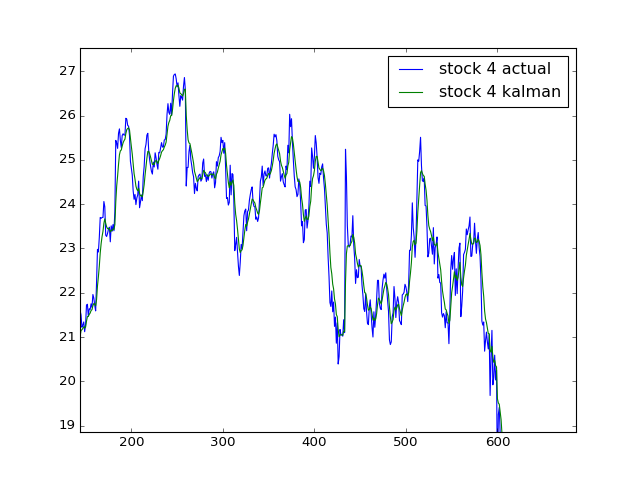

In [10]:
plt.figure()
plt.plot(data[4,:], label="stock 4 actual")
plt.plot(kalman[4,:], label="stock 4 kalman")
plt.legend(loc="best")
plt.show()